# Introduction

This project aims to predict daily sales for each store using past sales data. The dataset includes details like transactions, promotions, and holidays. But it also has problems like missing data, sudden changes, seasonal effects, and big jumps during sales offers. These issues make simple forecasting methods less accurate, so this project tries advanced machine learning models—XGBoost and Random Forest.

The goals of this study are - to understand and clean the dataset, to make new features from date and sales columns, to build and compare two models (Random Forest and XGBoost), to check model accuracy using error values, to see which features matter most for sales predictions, and to give useful business suggestions based on the results.

**About the Dataset**

The data for this project comes from the Store Sales Time Series Forecasting competition on Kaggle. It has daily sales records from Corporación Favorita, a big grocery company in Ecuador. The main goal is to predict how many units of each product will be sold in different stores on a given day.

The dataset is made up of several CSV files. Each file has different information, like store details, transactions, oil prices, holidays, and promotions. All these files were joined together to make a single dataset for time series forecasting. The data covers the period from January 1, 2013, to August 15, 2017. This includes many holidays, economic events, and special offers across 54 stores for more than four years.

The target column in this project is "sales." This shows the number of units sold for every product in each store every day.


In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, RandomizedSearchCV)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])

In [3]:
# View basic info, missing values and first 5 observations of stores dataset
print("\nStores Data Info:")
print(stores.info())

print("\nStores missing values:", stores.isnull().sum())

print("\nStores first 5 observations:")
print(stores.head())


Stores Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None

Stores missing values: store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Stores first 5 observations:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domi

In [4]:
# View basic info, missing values and first 5 observations of oil dataset
print("\nOil Data Info:")
print(oil.info())

print("\nOil missing values:")
print(oil.isnull().sum())

print("\nOil first 5 observations:")
print(oil.head())


Oil Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None

Oil missing values:
date           0
dcoilwtico    43
dtype: int64

Oil first 5 observations:
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


In [5]:
# View basic info, missing values and first 5 observations of holidays dataset
print("\nHolidays Data Info:")
print(holidays.info())

print("\nHolidays missing values:")
print(holidays.isnull().sum())

print("\nHolidays first 5 observations:")
print(holidays.head())


Holidays Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None

Holidays missing values:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Holidays first 5 observations:
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 

In [6]:
# View basic info, missing values and first 5 observations of transactions dataset
print("\nTransactions Data Info:")
print(transactions.info())

print("\nTransactions missing values:", transactions.isnull().sum())

print("\nTransactions first 5 observations:")
print(transactions.head())


Transactions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
None

Transactions missing values: date            0
store_nbr       0
transactions    0
dtype: int64

Transactions first 5 observations:
        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922


In [7]:
# View basic info, missing values and first 5 observations of train dataset
print("\nTrain Data Info:")
print(train.info())

print("\nTrain missing values:", train.isnull().sum())

print("\nTrain first 5 observations:")
print(train.head())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

Train missing values: id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Train first 5 observations:
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0     

# Data Preprocessing

In [8]:
# Change column names that are similar but represents a different feature
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [9]:
# Merge datasets
data = train.merge(stores, on = 'store_nbr', how='left')
data = data.merge(oil, on = 'date', how='left')

# Merge with holidays (only non-transferred holidays)
holidays = holidays[holidays['transferred'] == False]
data = data.merge(holidays[['date', 'holiday_type', 'locale']], on='date', how='left')
data['is_holiday'] = data['holiday_type'].notnull().astype(int)

data = data.merge(transactions, on = ['date', 'store_nbr'], how='left')

data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,1,NaN


In [10]:
# Display basic information about the combined dataset
print("\nData Info:")
print(data.info())

# Summary statistics
print("\nSummary Statistics:")
pd.options.display.float_format = '{:f}'.format
print(data.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   store_type    object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  is_holiday    int64         
 14  transactions  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 349.5+ MB
None

Summary Statistics:
                  id                           date      store_nbr  \
count 3054348.000000                        3054348 3054348.000000   
mean  1504276.775379  2015-04-26 12:11:45.717619

In [11]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Check date range
print("\nDate range:")
print("From:", data['date'].min())
print("To:", data['date'].max())


Missing values:
id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico       955152
holiday_type    2567862
locale          2567862
is_holiday            0
transactions     249117
dtype: int64

Date range:
From: 2013-01-01 00:00:00
To: 2017-08-15 00:00:00


In [12]:
data.shape

(3054348, 15)

In [13]:
## Handle missing values
data.fillna({
    'holiday_type': 'Work Day',
    'transactions' : 0,
    'locale'       : 'No Holiday'
}, inplace=True)

# Interpolate missing oil prices
data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear', limit_direction='both')

In [14]:
# Create time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [15]:
# Feature Engineering: Store×Family lag & rolling‐window statistics
group_cols = ['store_nbr', 'family']
g = data.groupby(group_cols)['sales']

# Create lag and rolling features (all lagged by 1 day):
#   • lag_1         = sales on the previous day
#   • roll_mean_7   = 7-day moving average of sales
#   • roll_std_7    = 7-day moving standard deviation of sales
data['lag_1']        = g.transform(lambda x: x.shift(1))
data['roll_mean_7']  = g.transform(lambda x: x.shift(1).rolling(window=7).mean())
data['roll_std_7']   = g.transform(lambda x: x.shift(1).rolling(window=7).std())

# Drop rows where any of the new features are NaN (i.e. the first few days per group)
data = data.dropna(subset=['lag_1', 'roll_mean_7', 'roll_std_7']) \
           .reset_index(drop=True)

print("After lag/rolling feature creation, data shape:", data.shape)

After lag/rolling feature creation, data shape: (3041874, 22)


In [16]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,locale,is_holiday,transactions,year,month,day_of_week,is_weekend,lag_1,roll_mean_7,roll_std_7
0,12474,2013-01-08,1,AUTOMOTIVE,2.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,2.142857,1.772811
1,12475,2013-01-08,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,0.000000,0.000000
2,12476,2013-01-08,1,BEAUTY,3.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,1.000000,1.285714,1.380131
3,12477,2013-01-08,1,BEVERAGES,1029.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,1158.000000,812.571429,442.221233
4,12478,2013-01-08,1,BOOKS,0.000000,0,Quito,Pichincha,D,13,...,No Holiday,0,1869.000000,2013,1,1,0,0.000000,0.000000,0.000000


# EDA

In [17]:
# Configure matplotlib for nicer defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

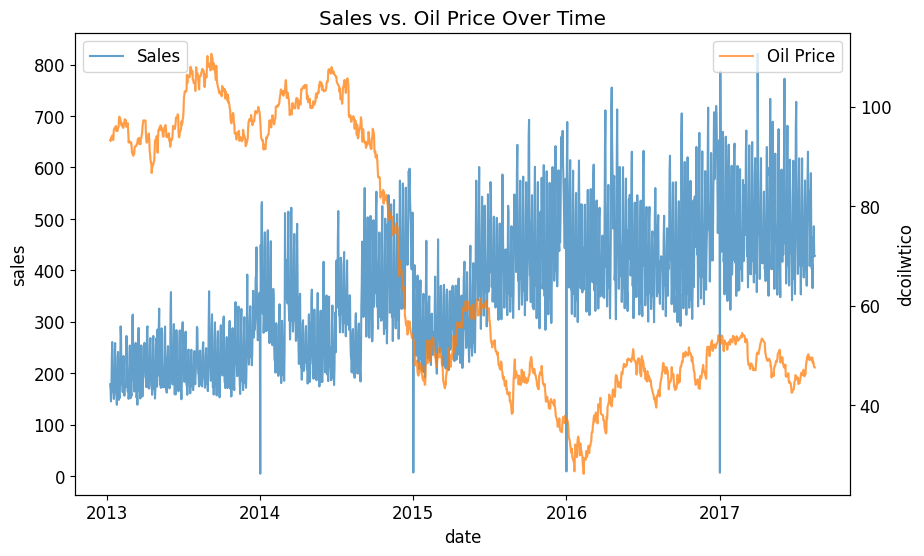

In [18]:
# Oil Price vs. Sales (Line Chart)
sns.lineplot(data=data, x='date', y='sales', color='tab:blue', label='Sales', alpha=0.7, errorbar=None)
ax2 = plt.gca().twinx() # Get the current axes and create a twin
sns.lineplot(data=data, x='date', y='dcoilwtico', color='tab:orange', label='Oil Price', alpha=0.7, ax=ax2)
plt.title('Sales vs. Oil Price Over Time')
plt.show()

The time series plot shows that sales slowly went up over the years, but oil prices followed a different trend. Oil prices increased at first, then dropped a lot around 2015, and stayed low after that. There is no strong direct link between sales and oil price, but during the time when oil prices fell, sales became more unstable. This might mean that changes in oil prices can affect how people spend money, but not in a direct way.

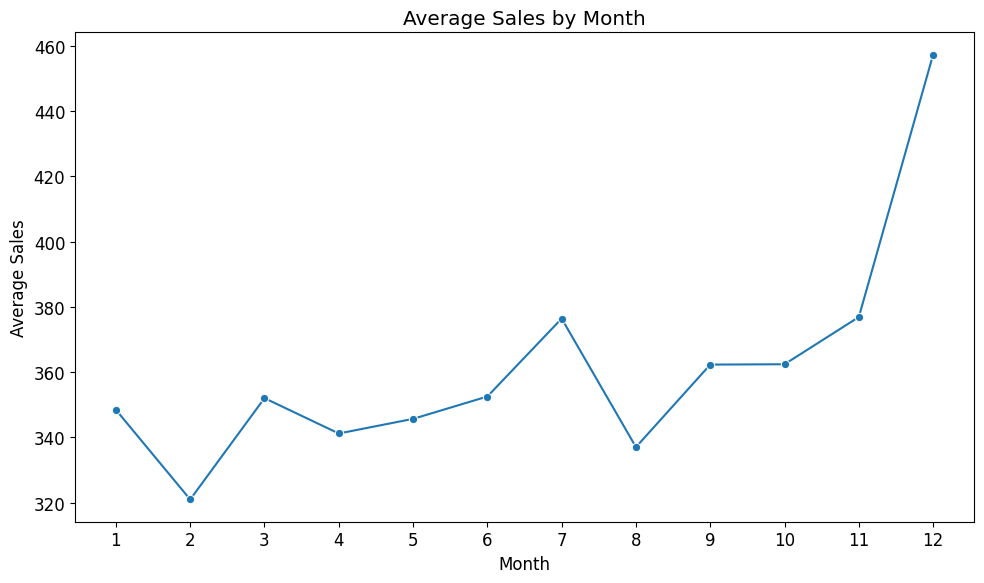

In [19]:
# Monthly Seasonality (Average Sales per Month)
monthly_avg = data.groupby('month')['sales'].mean().reset_index()

sns.lineplot(x='month', y='sales', data=monthly_avg, marker='o', color='tab:blue')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.title('Average Sales by Month')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

The monthly trend plot shows that sales go up and down in a regular pattern every year. Sales are lowest in February and highest in December. This is likely because of more shopping during holidays in December.

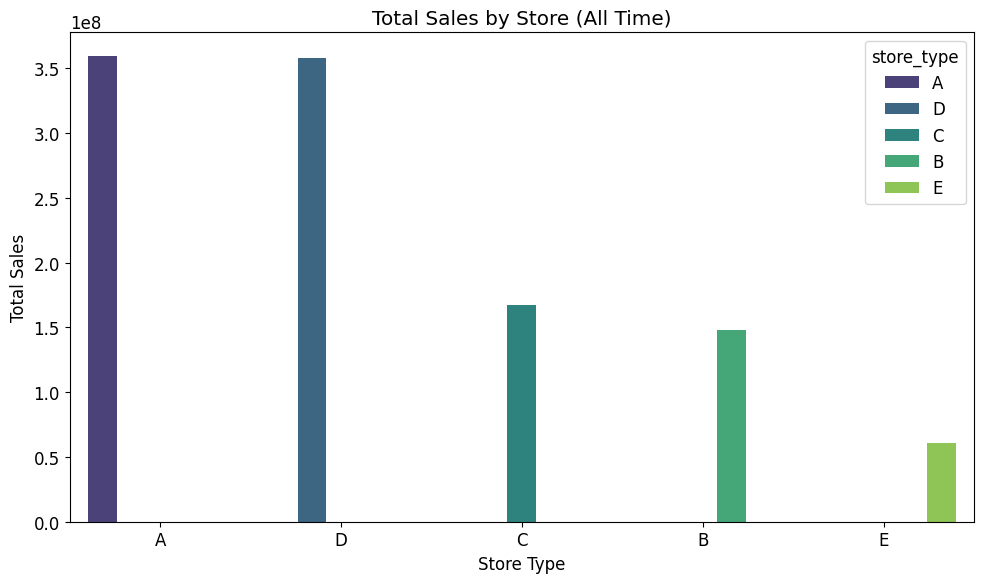

In [20]:
# Total Sales by Store Type
sales_by_store_type = data.groupby('store_type')['sales'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=sales_by_store_type, x='store_type', y='sales', hue='store_type', palette='viridis', )
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store (All Time)')
plt.tight_layout()
plt.show()

A bar chart comparing total sales in different store types shows that Type A and Type D stores have the highest total sales. They sell more than Type B, C, and E stores.

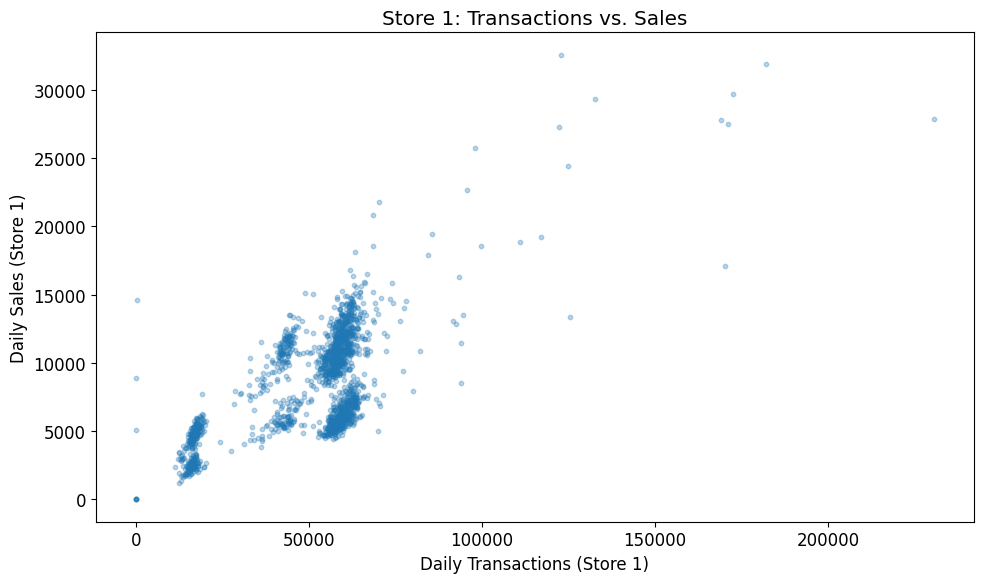

In [21]:
# Transactions vs. Sales (Example: Store #1, to see how transaction volume translates to revenue)
store_id = 1
store_sales = data[data['store_nbr'] == store_id].groupby('date')['sales'].sum().reset_index()
store_trans = data[data['store_nbr'] == store_id].groupby('date')['transactions'].sum().reset_index()

store_merged = store_sales.merge(store_trans, on='date', how='left').fillna(0)

plt.scatter(store_merged['transactions'], store_merged['sales'], alpha=0.3, s=10)
plt.xlabel(f'Daily Transactions (Store {store_id})')
plt.ylabel(f'Daily Sales (Store {store_id})')
plt.title(f'Store {store_id}: Transactions vs. Sales')
plt.tight_layout()
plt.show()

For Store 1, a plot of daily sales versus transactions shows a strong positive relation. Means, more transactions, sales also increase. So, transactions is an important feature for the model. 

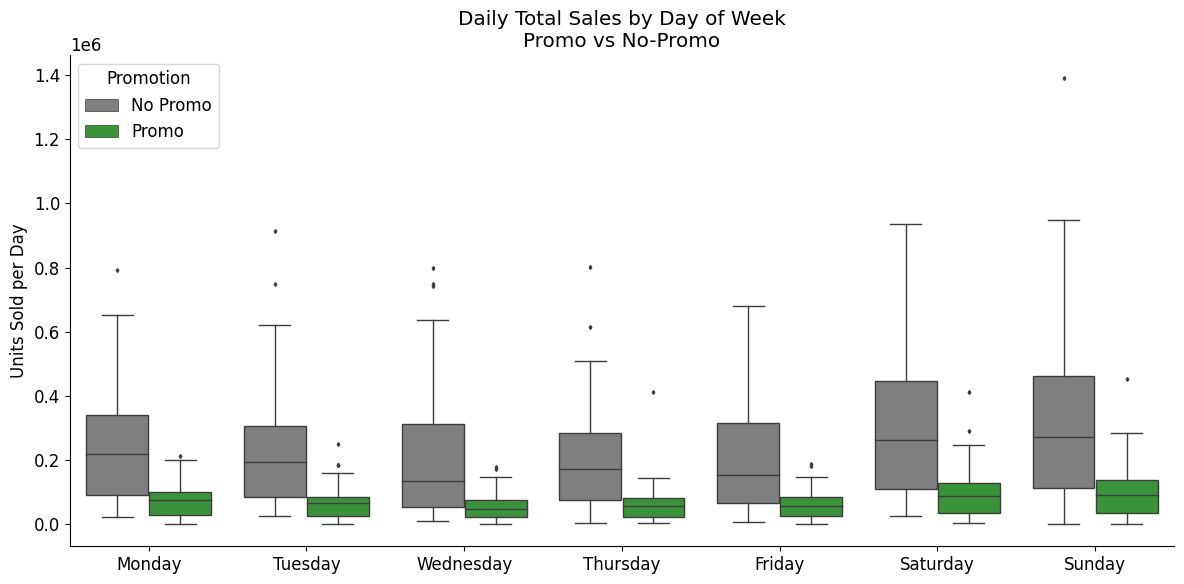

In [22]:
# Promotions affect daily sales
# Prepare a daily‐total table with promo flag
daily_promo = (
    data
    .groupby(['date','onpromotion'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'onpromotion':'promo_flag'})
)
# add human‐readable columns
daily_promo['day_name'] = daily_promo['date'].dt.day_name()
daily_promo['promo_flag'] = daily_promo['promo_flag'].map({0:'No Promo', 1:'Promo'})

# Define order & palette
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
palette = {'No Promo':'tab:gray','Promo':'tab:green'}

# Draw
plt.figure(figsize=(12,6))
sns.boxplot(
    data=daily_promo,
    x='day_name', y='sales', hue='promo_flag',
    order=order, palette=palette,
    fliersize=2,      # tiny dots for outliers
    linewidth=1
)

# Tidy up
plt.title('Daily Total Sales by Day of Week\nPromo vs No-Promo')
plt.xlabel('')
plt.ylabel('Units Sold per Day')
#plt.xticks(rotation=45)
plt.legend(title='Promotion', loc='upper left')
sns.despine(left=False, bottom=False)
plt.tight_layout()
plt.show()


The box plot shows average daily sales for each day of the week, grouped by whether the product was on promotion or not. On all days, products on promotion have higher average sales than those not on promotion. The effect of promotion is strongest on Saturday and Sunday.

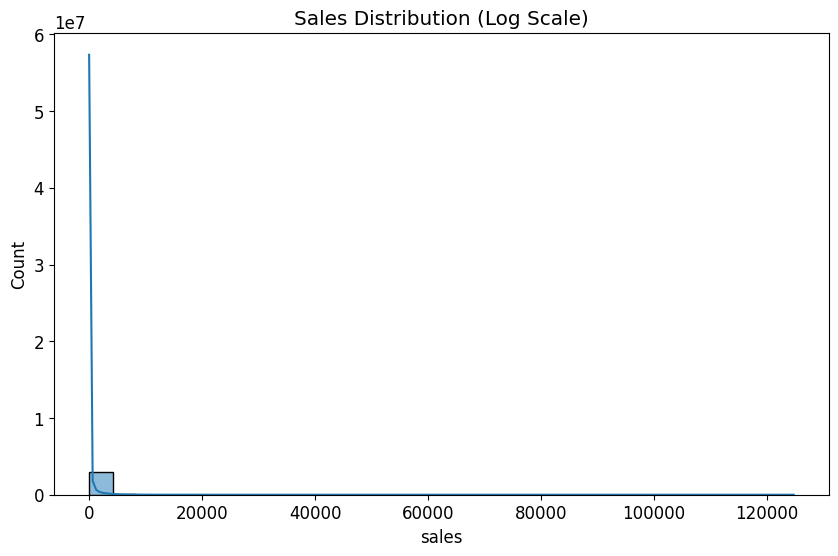

In [23]:
# Sales Distribution (Histogram)
# To check the distribution of sales and identify outliers

sns.histplot(data=data, x='sales', bins=30, kde=True)
plt.title('Sales Distribution (Log Scale)')
plt.show()

The histogram, with a log scale on the x-axis, shows most sales values are low, with many records at one unit sold. There is also a long tail with some very high sales numbers, showing there are extreme outliers in the data. 

In retail sales data, it is common to see many products with low sales and a few with very high sales. This can happen because some products are daily-use items and sell in small numbers, while others are popular or expensive and sell in large quantities. High sales can also be due to promotions, holidays, or special events that increase demand for certain items. This kind of uneven distribution is normal in retail and needs to be considered while building forecasting models, as it can affect how the model learns and predicts future sales.

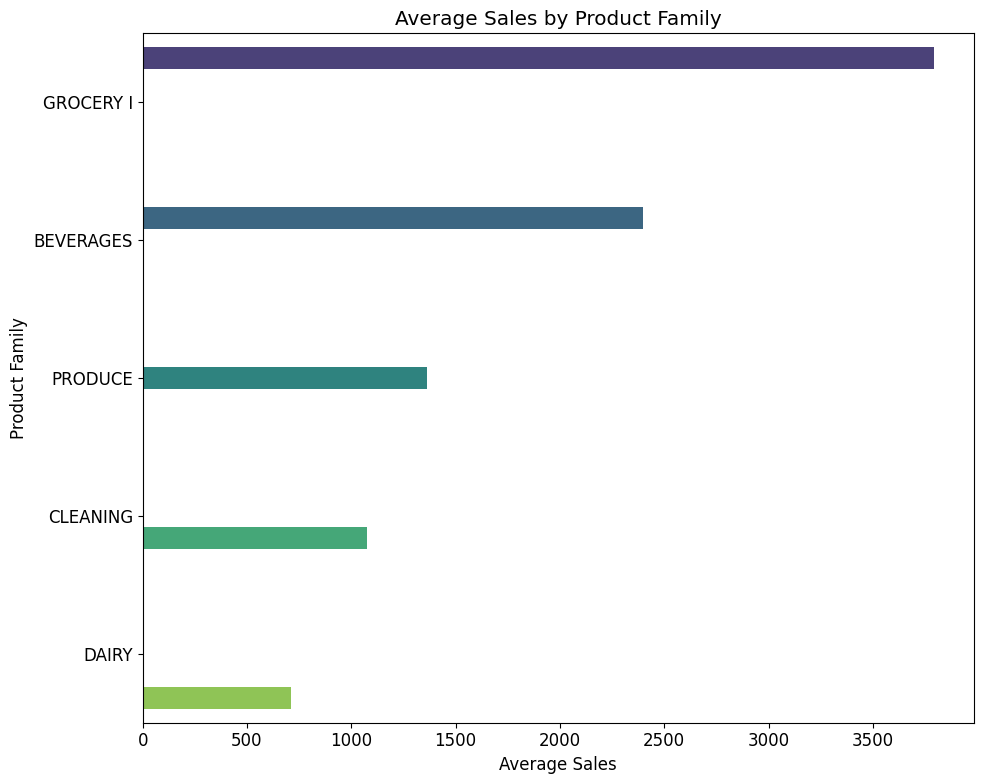

In [24]:
### Sales by Product Family (Bar Chart)
## To compare sales across product categories

# Calculate average sales per product family
avg_sales_family = data.groupby('family')['sales'].mean().sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(
    data=avg_sales_family,
    x='sales',
    y='family',
    hue='family',
    palette='viridis'
)
plt.gca().legend_.remove() 
plt.title('Average Sales by Product Family')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()


A horizontal bar chart ranks product families by average sales. Grocery I, Beverages, and Produce have the highest average sales. This means these items are sold the most and have steady demand.

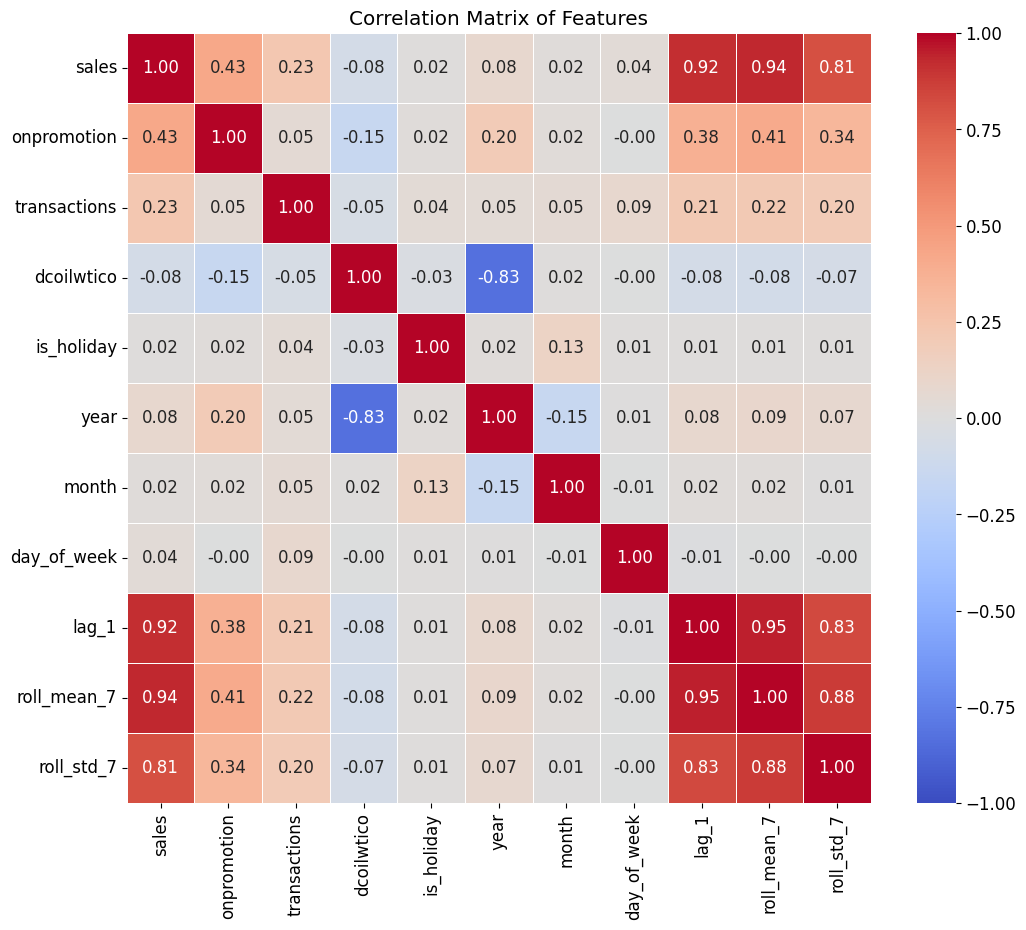

In [25]:
# Correlation Heatmap of Numerical Features

# Select only numeric features

corr_cols = [
    'sales', 'onpromotion', 'transactions', 'dcoilwtico', 'is_holiday',
    'year', 'month', 'day_of_week',
    'lag_1', 'roll_mean_7', 'roll_std_7'
]
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Features')
plt.show()

A correlation heatmap shows how features are related to the target. Showed strong relationships between sales and some past sales features like lag_1 and roll_mean_7. There was also a medium-level link with roll_std_7, which shows sales changes over the past week. Oil prices and promotions had weak links with sales. This means their effect on sales may change with time or other conditions. 

In [26]:
# Drop non-informative & redundant features
#    • id, date: identifiers, not inputs
#    • is_weekend: redundant with day_of_week
to_drop = ['id', 'date', 'is_weekend']
data = data.drop(columns=to_drop)
data.select_dtypes(include='object').columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type', 'locale'], dtype='object')

In [27]:
# Encode categorical columns
label_enc = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = label_enc.fit_transform(data[col].astype(str))

data.head()

,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,holiday_type,locale,is_holiday,transactions,year,month,day_of_week,lag_1,roll_mean_7,roll_std_7
0,1,0,2.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,2.142857,1.772811
1,1,1,0.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,0.000000,0.000000
2,1,2,3.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,1.000000,1.285714,1.380131
3,1,3,1029.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,1158.000000,812.571429,442.221233
4,1,4,0.000000,0,18,12,3,13,93.210000,5,2,0,1869.000000,2013,1,1,0.000000,0.000000,0.000000


# Random Sampling 

In [28]:
# Take a random sample of the data
sample_frac = 0.10   # 10% sample → ~300 K rows
data_sample = data.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
print("Sampled data shape:", data_sample.shape)

Sampled data shape: (304187, 19)


In [29]:
# Regression Model Development and Evaluation
# Prepare data for modeling
X = data_sample.drop('sales', axis=1)
y = data_sample['sales']

In [30]:
# Split data into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [31]:
# Normalize features
scaler_features = StandardScaler()
X_train = scaler_features.fit_transform(X_train)
X_test = scaler_features.transform(X_test)
X_val = scaler_features.transform(X_val)

In [32]:
## Hyperparameter Tuning with RandomizedSearchCV
# Time Series Cross-Validator
tscv = TimeSeriesSplit(n_splits=3)

# Model Training

In [33]:
# XGBoost Tuning
xgb = XGBRegressor(eval_metric='mae', random_state=42)

xgb_param_dist = {
    'n_estimators':       [100, 200],
    'max_depth':          [3, 5],
    'learning_rate':      [0.05, 0.1],
    'subsample':          [0.8],
    'colsample_bytree':   [0.8],
    'reg_lambda':         [0.5, 1.0, 2.0]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,                           # only 20 random combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_xgb.fit(X_train, y_train)

# Best parameters
print("\nBest XGBoost Parameters:")
print(rand_xgb.best_params_)

# Best model
best_xgb = rand_xgb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best XGBoost Parameters:
{'subsample': 0.8, 'reg_lambda': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [34]:
# Random Forest Tuning
rf = RandomForestRegressor(random_state=42)

rf_param_dist = {
    'n_estimators':       [100],
    'max_depth':          [3, 5],
    'min_samples_split':  [20, 50],
    'min_samples_leaf':   [10, 20]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=3,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

rand_rf.fit(X_train, y_train)


# Best parameters
print("\nBest Random Forest Parameters:")
print(rand_rf.best_params_)

# Best model
best_rf = rand_rf.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best Random Forest Parameters:
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 5}


In [35]:
# Define your splits and models
splits = {
    "Train":     (X_train, y_train),
    "Validation":(X_val,   y_val),
    "Test":      (X_test,  y_test),
}
models = {
    "XGBoost":     best_xgb,
    "RandomForest":best_rf,
}

# Collect all metrics in a flat list of dicts
records = []
for split_name, (X, y_true) in splits.items():
    for model_name, model in models.items():
        y_pred = model.predict(X)
        records.append({
            "Model":  model_name,
            "Split":  split_name,
            "MAE":    mean_absolute_error(y_true, y_pred),
            "MSE":    mean_squared_error(y_true, y_pred),
            "R2":     r2_score(y_true, y_pred),
        })

df = pd.DataFrame(records)

# Model Performance Summary

print("\nModel Performance Summary:")
table = (
    df
      .melt(
         id_vars=["Model","Split"],
         value_vars=["MAE","MSE","R2"],
         var_name="Metric",
         value_name="Score"
      )
      .pivot(index="Metric", columns=["Model","Split"], values="Score")
      .round(2)
)
print(table)


Model Performance Summary:
Model       XGBoost RandomForest      XGBoost RandomForest      XGBoost  \
Split         Train        Train   Validation   Validation         Test   
Metric                                                                    
MAE       48.720000    73.040000    56.160000    76.060000    55.560000   
MSE    24672.080000 72173.440000 46427.890000 81679.920000 47748.770000   
R2         0.980000     0.940000     0.960000     0.930000     0.960000   

Model  RandomForest  
Split          Test  
Metric               
MAE       76.420000  
MSE    86115.560000  
R2         0.930000  


# Model Performance Summary

The comparison shows that XGBoost Regressor gives better results than Random Forest Regressor in predicting sales. As seen in Table 3, XGBoost has a lower Mean Absolute Error (MAE) of 55.56, while Random Forest has 76.42. The Mean Squared Error (MSE) for XGBoost is 47,748.8, which is also lower than Random Forest’s 86,115.6. For R², which tells how much the model explains the changes in sales, XGBoost scores 0.96 and Random Forest scores 0.93.

# Model Comparison

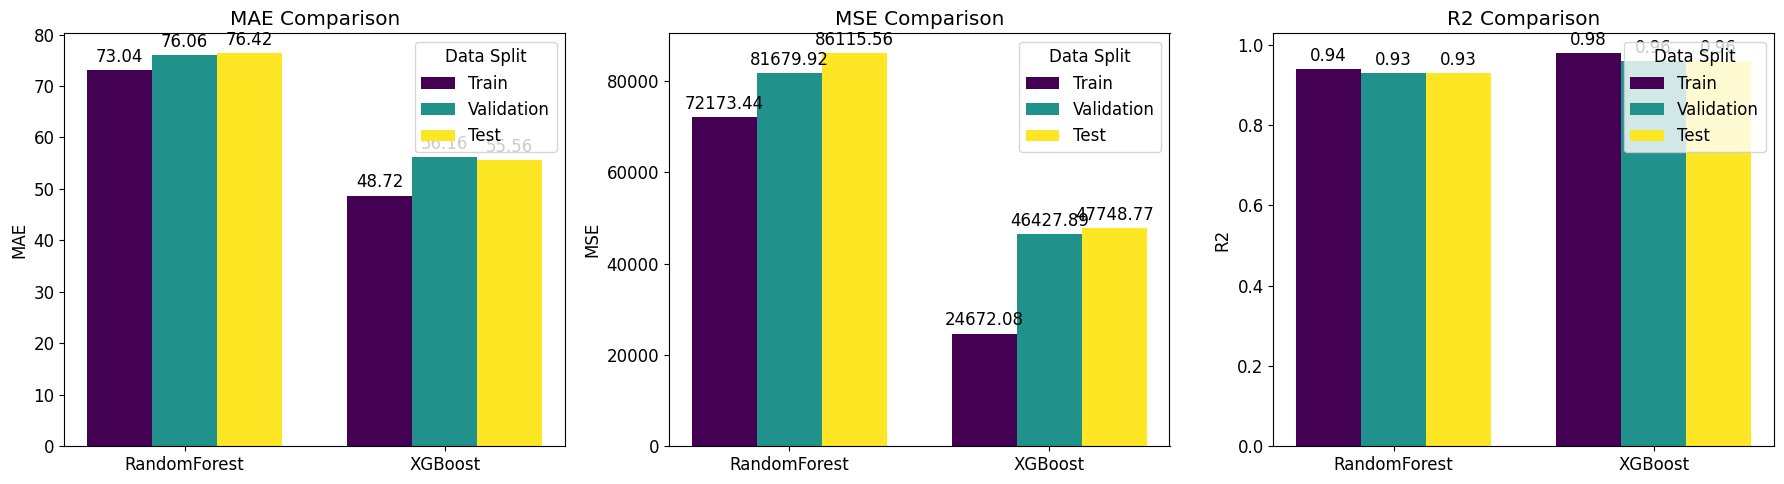

In [36]:
# Bar plot to compare metrics
metrics = ["MAE", "MSE", "R2"]
splits_order = ["Train", "Validation", "Test"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
cmap = plt.get_cmap("viridis")
n = len(splits_order)
colors = [cmap(i/(n-1)) for i in range(n)]

for ax, metric in zip(axes, metrics):
    # Data for this metric: models × splits
    dfm = table.loc[metric].unstack(level=1).reindex(columns=splits_order)
    x = np.arange(len(dfm.index))
    width = 0.25

    for i, split in enumerate(splits_order):
        bars = ax.bar(x + i*width, dfm[split], width,
                      label=split, color=colors[i])
        # annotate each bar
        ax.bar_label(bars, padding=3, fmt="%.2f")

    ax.set_xticks(x + width, dfm.index)
    ax.set_title(f"{metric} Comparison")
    ax.set_ylabel(metric)
    ax.legend(title="Data Split")

fig.tight_layout()
plt.show()

Bar charts that compare the MAE, MSE, and R² scores across training, validation, and test sets. XGBoost performs better in all three sets, with lower error and higher R².

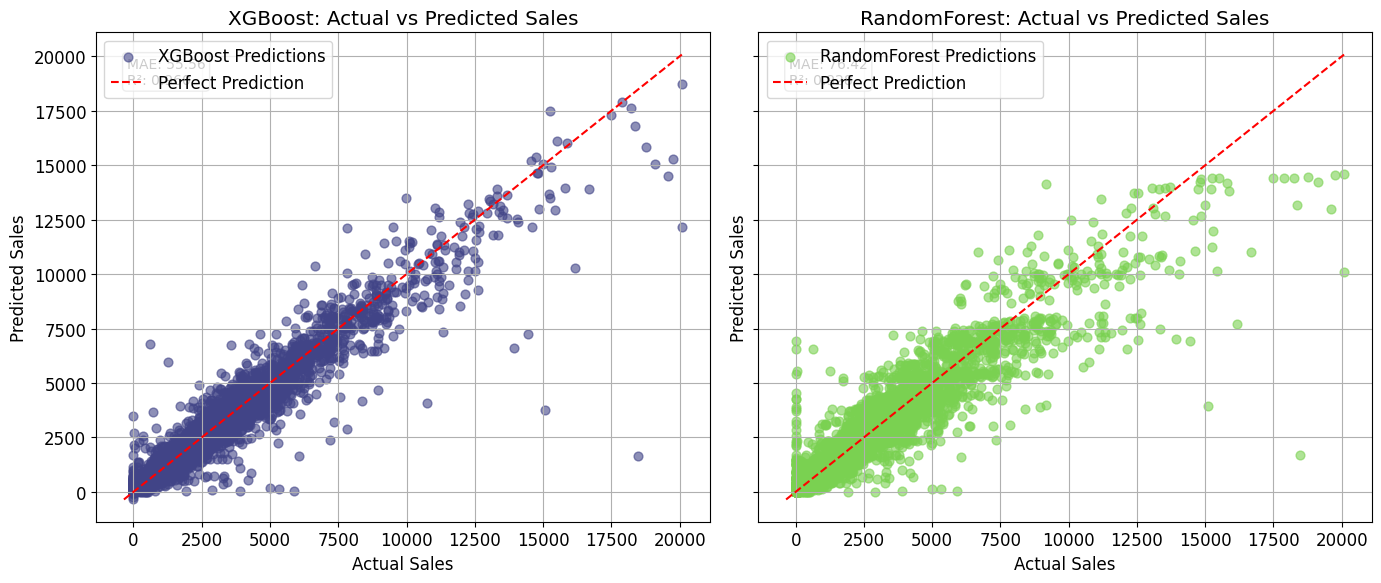

In [37]:
# Actual vs Predicted Sales
X_test_data, y_test_data = X_test, y_test  # adjust if your variable names differ
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Get predictions
preds = {name: model.predict(X_test_data) for name, model in models.items()}

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
cmap = plt.get_cmap("viridis")
colors = [cmap(0.2), cmap(0.8)]  # pick two distinct viridis colors

# Determine common plot limits
all_actual = y_test_data
all_predicted = np.concatenate(list(preds.values()))
mn = min(all_actual.min(), all_predicted.min())
mx = max(all_actual.max(), all_predicted.max())

for ax, (name, y_pred), color in zip(axes, preds.items(), colors):
    # scatter
    ax.scatter(y_test_data, y_pred, alpha=0.6, s=40, color=color, label=f"{name} Predictions")
    # perfect-prediction line
    ax.plot([mn, mx], [mn, mx], linestyle="--", color="red", label="Perfect Prediction")

    # metrics
    mae = mean_absolute_error(y_test_data, y_pred)
    r2  = r2_score(y_test_data, y_pred)
    text = f"MAE: {mae:.2f}\nR²: {r2:.3f}"
    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        fontsize=10,
        va="top",
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7, boxstyle="round")
    )

    # labels & title
    ax.set_title(f"{name}: Actual vs Predicted Sales")
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    ax.grid(True)
    ax.legend()

# tighten & show
fig.tight_layout()
plt.show()

XGBoost’s points are closer to the diagonal line, which means its predictions are more accurate. Random Forest’s points are more spread out, especially at higher sales, showing more error in those predictions.

# Feature Importance Analysis

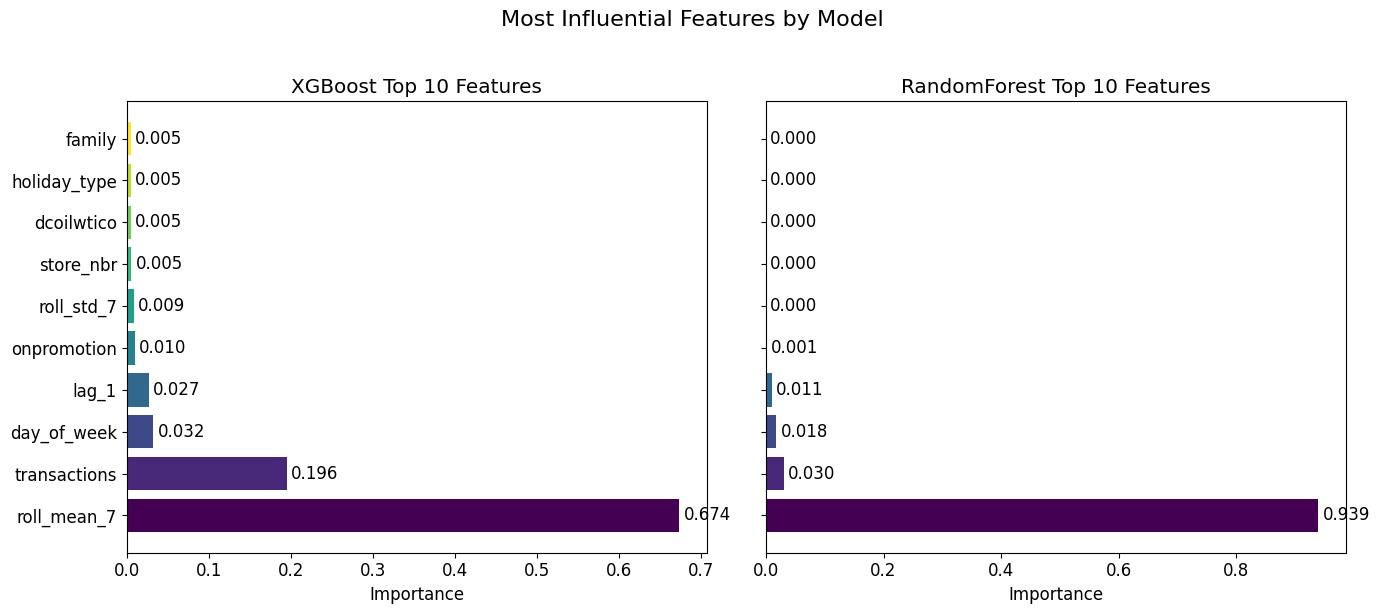

In [38]:
# Identify the most influential features affecting the target variable
# Get feature names (all columns except the target 'sales')
feature_names = [c for c in data_sample.columns if c != "sales"]

# Trained models
models = {
    "XGBoost":      best_xgb,
    "RandomForest": best_rf,
}

# Number of top features to show
top_n = 10

# Extract & sort importances for each model
imps = {}
for name, model in models.items():
    vals   = model.feature_importances_
    series = pd.Series(vals, index=feature_names)
    imps[name] = series.sort_values(ascending=False).head(top_n)

# Plot side-by-side horizontal bars with viridis colormap
fig, axes = plt.subplots(1, len(models), figsize=(14, 6), sharey=True)
cmap   = plt.get_cmap("viridis")
colors = [cmap(i/(top_n-1)) for i in range(top_n)]

for ax, (name, imp_series) in zip(axes, imps.items()):
    # positions & bars
    y_pos = np.arange(len(imp_series))
    bars  = ax.barh(y_pos, imp_series.values, color=colors)

    # label each bar with its importance value
    ax.bar_label(bars, fmt="%.3f", padding=3)

    # set y-ticks to feature names and invert so the highest importance is at the top
    ax.set_yticks(y_pos)
    ax.set_yticklabels(imp_series.index)
    ax.invert_yaxis()

    # titles and grid
    ax.set_title(f"{name} Top {top_n} Features")
    ax.set_xlabel("Importance")

# overall title and layout
fig.suptitle("Most Influential Features by Model", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()

Both models give the most importance to roll_mean_7, which is the 7-day average of past sales. XGBoost also gives importance to transactions and lag_1, while Random Forest mostly depends on roll_mean_7. This shows that past sales data is useful for predicting future sales, and features like recent averages and past values help the model make better forecasts.

XGBoost also uses other features like transactions, day_of_week, and lag_1, while Random Forest mostly focuses on roll_mean_7. This means that the rolling average itself carries a strong signal for making predictions. Using rolling averages makes sense because they show trends, patterns across time, and recent changes in sales. 

# Conclusion 

This study shows that advanced machine learning models, especially XGBoost, work well for predicting daily retail sales using time-based features. The performance results show that XGBoost gives better and more reliable results than Random Forest in all the tests.

Based on this analysis, the following suggestions are given:

* Focus on Recent Sales Data: Models should use features like rolling averages and past day sales, as they help in better predictions.
* Use XGBoost for Forecasting: Since XGBoost gave better results, it is suggested as the main model for future sales prediction tasks. 
* Plan Promotions Smartly: Since promotions affect sales, use past data to find the best times to run them. Plan them around holidays or seasons when demand is high. 

These results show that using time series data with the right models can help improve sales forecasts and support better business decisions.
